# 1. Load libraries

In [1]:
import spotipy, pandas as pd
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from itertools import combinations
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# 2. Spotify authorization and some sample playlists to play around with

##### If you want to run all this analysis with your own playlist and play around with choosing features, just replace the playlist url with one to your playlist.

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
playlist = 'https://open.spotify.com/playlist/1Iy9WMwbPSJ7FiOUAsfWxC?si=02f0d2f4b50046e9'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))
user = sp.me()['id']

# 3. Song and feature extraction

##### sp.playlist_tracks returns json-formatted information about the songs in a playlist, up to 100 at a time
##### sp.audio_features returns json-formatted audio features about a list of songs, up to 50 at a time

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset += len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'key', 'time_signature', 'mode'], axis=1)

##### Descriptive statistics are below. Many features, like instrumentalness, have significantly larger standard deviations than meeans. This comes from the fact that most songs are clustered near values of 0 or 1. These features are designed by Spotify to capture whether or not something is true of the song, i.e. if it contains no vocals, was performed live, or is acoustic. This allows clusters based on these features to have very high silhouette scores, but the playlists these clusters create have songs grouped in ways that would not make sense to a human listener. I have alrady dropped mode, which denotes whether a song is in a [Major or Minor key](https://en.wikipedia.org/wiki/Major_and_minor), for being a binary variable. Going forward, I will also be dropping variables whose values are clustered near 0 and 1 and as such act as binary variables. For a more detailed explanation of audio features, see [Spotify's documentation](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features).

###### Of minor note, the difference between major and minor keys is a distinction largely unique to Western music; other musical traditions have different ways of distinguishing scales/modes. So in addition to mode being a bad statistic to use because it does too god a job of grouping songs into two groups, it would also struggle with non-Western music.

In [6]:
df_feats.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,0.650574,0.600296,-7.282487,0.142464,0.241101,0.040276,0.191807,0.454867,120.172363
std,0.161634,0.183476,3.025320,0.121997,0.264688,0.169732,0.146155,0.208842,30.459716
min,0.210000,0.012200,-28.906000,0.023500,0.000068,0.000000,0.040400,0.032400,59.850000
25%,0.539000,0.476000,-8.685000,0.044000,0.031700,0.000000,0.101000,0.296000,94.997000
50%,0.653000,0.619000,-6.737000,0.090600,0.136000,0.000000,0.131000,0.446000,118.963000
75%,0.779000,0.743000,-5.212000,0.220000,0.371000,0.000084,0.249000,0.613000,139.956000
max,0.958000,0.946000,-1.218000,0.558000,0.992000,0.946000,0.900000,0.916000,205.863000


##### As a brief note, features already normed by Spotify like "energy" and "valence" are also normed below, as all songs spotify has being normed on these features does not guarantee an even distribution in the inputted playlist.

In [7]:
df_feats.drop(['speechiness', 'instrumentalness', 'liveness', 'acousticness'], axis=1, inplace=True)

In [8]:
to_norm = df_feats[['loudness', 'tempo', 'danceability', 'energy', 'valence']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness', 1: 'tempo', 2: 'danceability', 3: 'energy', 4: 'valence'})

In [9]:
df_feats.drop(['loudness', 'tempo', 'danceability', 'energy', 'valence'], axis=1, inplace=True)

In [10]:
# We need the dataframe with the ids preserved later for playlist creation, and create one with song ids as the index for purposes of clustering
df_total = df_feats.join(df_normed)
df_feats = df_total.set_index('id')

# 4. Choosing features to cluster on

##### I create a correlations heatmap below. Of note here is the extremely high correlation between energy and loudness. I decided to drop loudness, as I did not want playlists sorted by the average decibals in a song.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


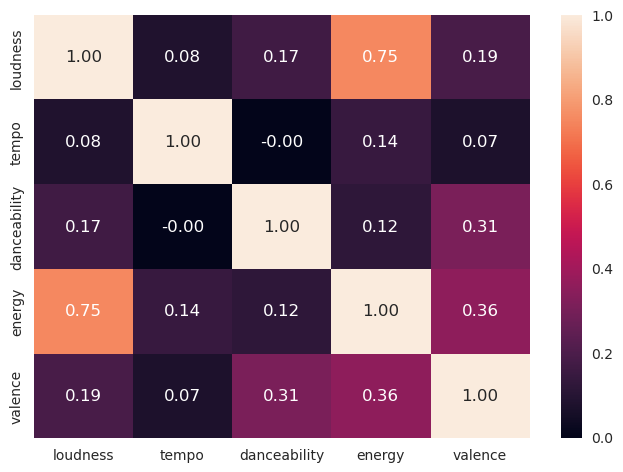

In [11]:
sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

In [12]:
df_feats.drop(['loudness'], axis=1, inplace=True)
df_total.drop(['loudness'], axis=1, inplace=True)

##### The code below finds silhouette scores and elbows for clusters based on each pair of features. Clustering on 3+ features is not done simply because in testing, no clusters using 5+ features performed well. Clusters using 3 or 4 features occasionally performed decently, but were always outperformed by clusters using only 2. Often times, clusters from 3 or 4 features were outperformed by a combination of only two of the features they contained.

##### Often, the combinations that yielded the highest silhouette score only outputted two playlists. The playlists I tested on had enough variety that I felt this was not enough clusters. Splitting music in half along two features, while accurate to those two features, actively covers up some of the actual differences in the music. As such, I created the 'total' column by multiplying each combination's score and elbow. This gives some weight to the silhouette score while also rewarding clustering algorithms that found more ways to split the inputted playlist.

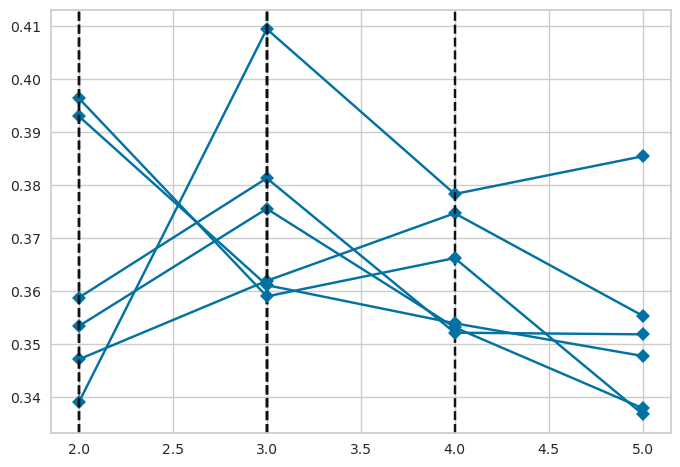

In [13]:
n_clusters = [2, 3, 4, 5, 6]
cols = list(df_feats)
score, value = [], []
combos = list(combinations(cols, 2))
for combo in combos:
    subset = df_feats[list(combo)]
    model = KElbowVisualizer(KMeans(), k=(min(n_clusters), max(n_clusters)), metric='silhouette', timings=False)
    model.fit(subset.values)
    score.append(model.elbow_score_)
    value.append(model.elbow_value_)

performance = {'score': score, 'elbow': value}
df_combos = pd.DataFrame(combos, columns=['feat_1', 'feat_2']).join(pd.DataFrame(performance))
df_combos['total'] = df_combos.apply(lambda combo: combo['score'] * combo['elbow'], axis=1)

##### Below I sort clusters by their 'total' scores. This is simply to get a sense of which clusters are performing well and to aid with choosing feature combinations to try in [app.py](app.py).

In [14]:
df_combos.sort_values(by=['total'], ascending=False)

,feat_1,feat_2,score,elbow,total
1,tempo,energy,0.374667,4,1.498666
0,tempo,danceability,0.409438,3,1.228314
3,danceability,energy,0.381290,3,1.143871
2,tempo,valence,0.375527,3,1.126580
5,energy,valence,0.396370,2,0.792739
4,danceability,valence,0.392976,2,0.785952


# 5. Playlist creation

##### I extract the features with the highest 'total' score below and use those to create clusters, and then playlists.

In [15]:
feat_1 = df_combos[df_combos['total']==df_combos['total'].max()]['feat_1'].values[0]
feat_2 = df_combos[df_combos['total']==df_combos['total'].max()]['feat_2'].values[0]
num_clusts = df_combos[df_combos['total']==df_combos['total'].max()]['elbow'].values[0]

df_to_cluster = df_total[['id', feat_1, feat_2]]
model = KMeans(n_clusters=num_clusts).fit(df_to_cluster[[feat_1, feat_2]].values)
clusters = {'cluster': model.labels_}
df_clustered = df_to_cluster.join(pd.DataFrame(clusters))

In [16]:
for i in range(num_clusts):
    songs = list(df_clustered['id'][df_clustered['cluster'] == i])
    name = f'created_playlist_{i}'
    current_playlists = []
    offset = 0
    while True:
        playlists = sp.current_user_playlists(limit=50, offset=offset)['items']
        if len(playlists) == 0:
            break
        current_playlists += [d['name'] for d in playlists]
        offset += len(playlists)
    if name in current_playlists:
        continue
    sp.user_playlist_create(user=user, name=name)
    new = sp.current_user_playlists(limit=1)['items'][0]['uri']
    if len(songs) > 100:
        j = 0
        while j < (len(songs)//100 + 1):
            sub_songs = songs[100*j:100*(1+j)]
            sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=sub_songs)
            j += 1
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs[-(len(songs)%100):])
    else:
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs)